In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.stats import oneway                         # ANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd    # post-hoc analýza po ANOVA
import statsmodels.api as sm
import scikit_posthocs as sp                                 # post-hoc analýza po ANOVA
import pingouin

# Načtení dat ze souboru 


In [2]:
aku = pd.read_csv('aku.csv', sep=';', index_col=0) #sep: oddělovač, index_col: číslo sloupce s indexem řádku (soubor jej nemusí obsahovat)

In [3]:
aku

,vyrobce,kapacita_5,kapacita_100
cislo,,,
1,A,1996,1717
2,A,2053,2134
3,A,2087,1981
4,A,2026,1834
5,A,2039,1941
...,...,...,...
124,D,2039,1795
125,D,2021,1948
126,D,2070,1858


In [4]:
aku.columns # názvy slupců v datovém souboru

Index(['vyrobce', 'kapacita_5', 'kapacita_100'], dtype='object')

In [5]:
aku.head() # výpis prvních řádků souboru

,vyrobce,kapacita_5,kapacita_100
cislo,,,
1,A,1996,1717
2,A,2053,2134
3,A,2087,1981
4,A,2026,1834
5,A,2039,1941


In [6]:
aku['vyrobce'].dtype # data ve slpupci jsou v obecného typu "object"

dtype('O')

In [7]:
aku['kapacita_5'].dtype

dtype('int64')

In [8]:
# sloupec lze převést na typ Category
aku['vyrobce']=aku['vyrobce'].astype('category')
# pro data typu Category můžeme zvolit vlastní pořadí kategorií (hodnot) 
aku['vyrobce']=aku['vyrobce'].cat.as_ordered() 
aku['vyrobce']=aku['vyrobce'].cat.reorder_categories(['C', 'B', 'A', 'D'])

In [9]:
aku['vyrobce'] # v posledním řádku vidíme, že kategorie jsou uspořádány podle zadaného pořadí

cislo
1      A
2      A
3      A
4      A
5      A
      ..
124    D
125    D
126    D
127    D
128    D
Name: vyrobce, Length: 128, dtype: category
Categories (4, object): ['C' < 'B' < 'A' < 'D']

# Explorační analýza

## Explorační analýza kategoriální proměnné

In [10]:
# četnosti výskytu jednotlivých kategoriíaku['vyrobce'].value_counts()

<Axes: ylabel='vyrobce'>

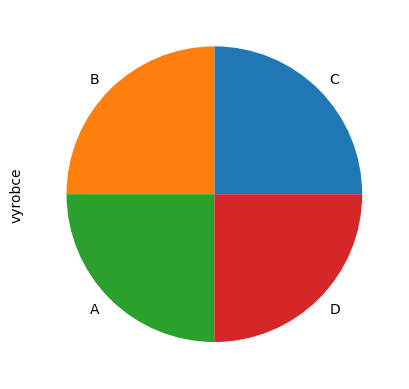

In [12]:
# koláčový graf
aku['vyrobce'].value_counts().plot.pie()

Text(0, 0.5, 'počet akumulátorů')

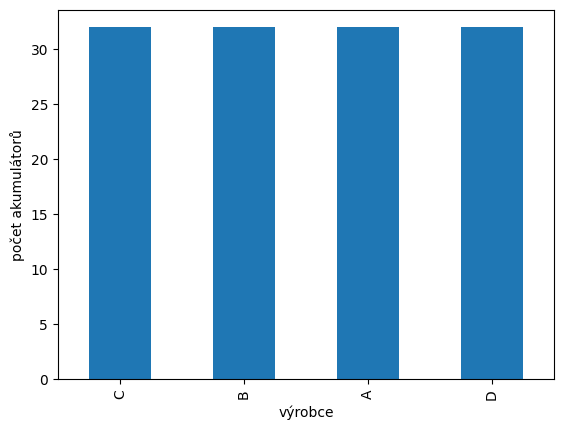

In [13]:
# sloupcový graf
aku['vyrobce'].value_counts().plot.bar()
plt.xlabel("výrobce")
plt.ylabel("počet akumulátorů")

## Explorační analýza kvantitativních proměnných

In [14]:
# základní numerické charakteristiky
aku.describe()

,kapacita_5,kapacita_100
count,128.00000,128.000000
mean,1987.93750,1828.492188
std,142.30309,179.292529
min,732.00000,620.000000
25%,1969.75000,1773.500000
50%,2005.00000,1846.000000
75%,2041.25000,1928.250000
max,2129.00000,2134.000000


Text(0, 0.5, 'četnost výskytu')

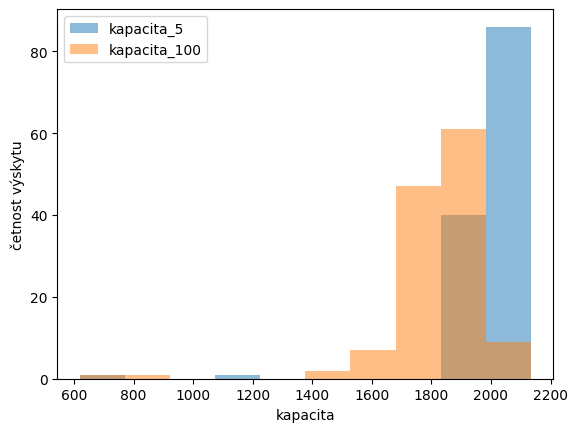

In [15]:
# histogramy
aku.plot.hist(alpha=0.5) 
plt.xlabel("kapacita")
plt.ylabel("četnost výskytu")

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0., 45., 81.]),
 array([ 732. ,  871.7, 1011.4, 1151.1, 1290.8, 1430.5, 1570.2, 1709.9,
        1849.6, 1989.3, 2129. ]),
 <BarContainer object of 10 artists>)

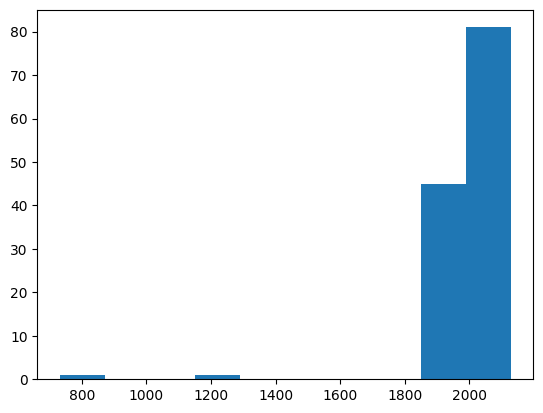

In [16]:
plt.hist(aku['kapacita_5'])

Text(0, 0.5, 'kapacita')

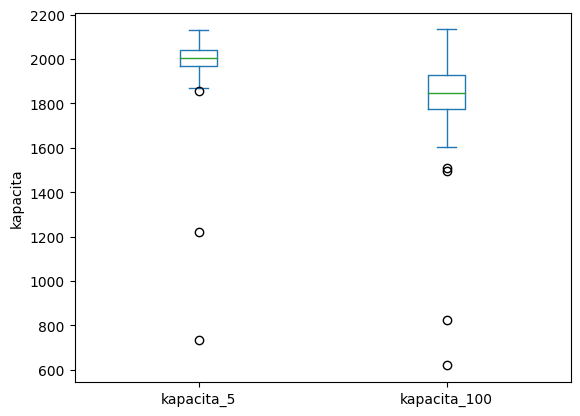

In [17]:
# krabicové grafy
aku.plot.box()
plt.ylabel("kapacita")

### Identifikace a odstranění odlehlých pozorování

In [20]:
# výpis řádků obsahujících odlehlá pozorování ve sloupci kapacit po 5 cyklech  (podle metody vnitřních hradeb)
Q1_5=aku['kapacita_5'].quantile(0.25)  # dolní kvartil
Q3_5=aku['kapacita_5'].quantile(0.75)  # horní kvartil
IQR_5 = Q3_5-Q1_5                      # interkvartilové rozpětí  
D = Q1_5-1.5*IQR_5                     # dolni hradba
H = Q3_5+1.5*IQR_5                     # horni hradba
out_5 = (aku['kapacita_5']<D) | (aku['kapacita_5']>H)   # identifikátory odlehlých pozorování (leží mimo vnitřní hradby)
print(aku[out_5])                             

      vyrobce  kapacita_5  kapacita_100
cislo                                  
20          A         732           620
33          B        1854          1841
88          C        1221           823


In [21]:
# ponecháme jen řádky obsahující v obou sloupcích hodnoty nad 1500 mAh (zbylé akumulároty jsou považovány za vadné)
aku = aku[(aku['kapacita_5']>=1500)&(aku['kapacita_100']>=1500)].copy() 

Text(0, 0.5, 'četnost výskytu')

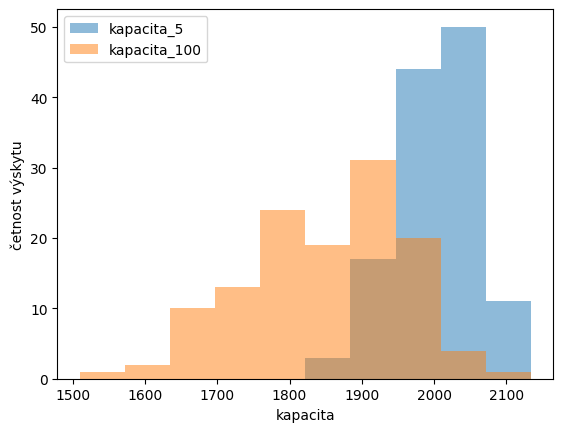

In [22]:
# histogramy po odstranění vadných akumulátorů
aku.plot.hist(alpha=0.5)
plt.xlabel("kapacita")
plt.ylabel("četnost výskytu")

Text(0, 0.5, 'kapacita')

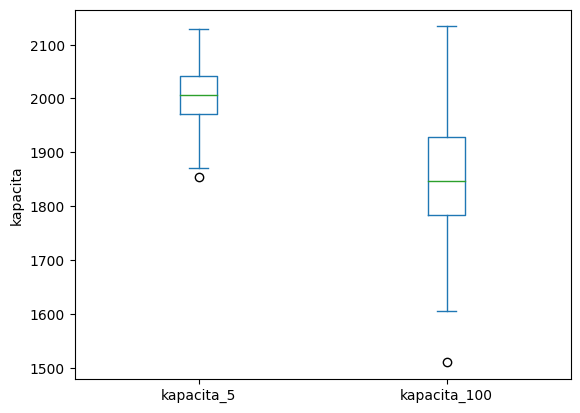

In [23]:
# krabicové grafy po odstranění vadných akumulátorů
aku.plot.box()
plt.ylabel("kapacita")

In [24]:
# základní charakteristiky pro data očištěná od odlehých pozorování
aku.describe()

,kapacita_5,kapacita_100
count,125.000000,125.000000
mean,2004.328000,1848.864000
std,54.768247,108.085341
min,1854.000000,1510.000000
25%,1971.000000,1783.000000
50%,2007.000000,1847.000000
75%,2042.000000,1929.000000
max,2129.000000,2134.000000


## Závislost dvou kvantitativních proměnných

<Axes: xlabel='kapacita_5', ylabel='kapacita_100'>

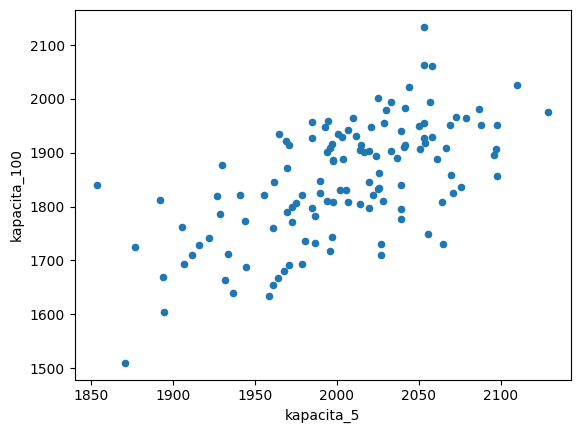

In [25]:
# bodový graf závislosti kapacit po 5 a kapacit po 100 cyklech
aku.plot.scatter(x='kapacita_5', y='kapacita_100')
# z rozložení bodů v grafu lze usoudit, že hodnoty kapacit po 5 a po 100 cyklech jsou vzájemně závislé

In [26]:
# Pearsonvy korelační koeficienty (bodové odhady korelací)
aku.corr() # pomocí pandas

/tmp/ipykernel_506008/501180030.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  aku.corr() # pomocí pandas


,kapacita_5,kapacita_100
kapacita_5,1.000000,0.621874
kapacita_100,0.621874,1.000000


In [27]:
np.corrcoef(aku['kapacita_5'], aku['kapacita_100']) # totéž pomocí numpy

array([[1.       , 0.6218736],
       [0.6218736, 1.       ]])

## Explorační analýza závislosti kvantitativní a kategoriální proměnné

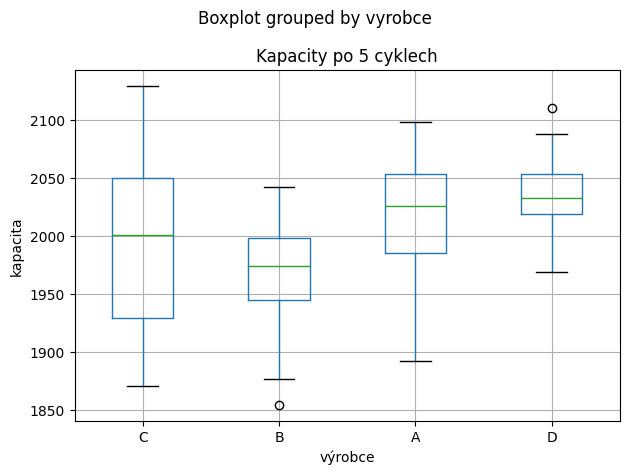

In [28]:
# krabicové grafy kapacit po 5 cyklech v zavislosti na vyrobci
aku.boxplot(column=['kapacita_5'], by=['vyrobce']);
plt.title('Kapacity po 5 cyklech')
plt.xlabel('výrobce')
plt.ylabel('kapacita')
plt.tight_layout() # upravi mezery kolem grafu
# výrazné posunutí krabicových grafů (např. B proti D) naznačuje závislost kapacity po 5 cyklech na výrobci

## Explorační analýza závislosti dvou kategoriálních proměnných

In [29]:
# pokles kapacit mezi 5. a 100. cyklem (přidáme jako další sloupec datového rámce)
aku['pokles']=aku['kapacita_5']-aku['kapacita_100']

In [30]:
# relativní pokles
aku['rel_pokles']=aku['pokles']/aku['kapacita_5']

In [31]:
# je relativní pokles > 0.1 ?
aku['pokles_nad10p'] = aku['rel_pokles']>0.1

In [32]:
# kontingenční tabulka (tabulka absolutních četností dvojic (výrobce, pokles > 0.1))
crt = pd.crosstab(aku['vyrobce'], aku['pokles_nad10p'])

In [33]:
crt

pokles_nad10p,False,True
vyrobce,,
C,17,14
B,27,5
A,16,14
D,29,3


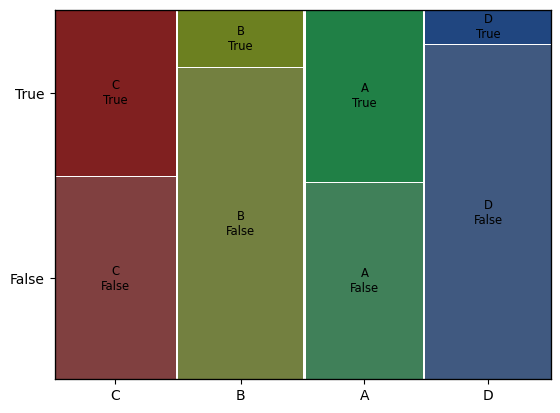

In [34]:
# mozaikový graf (grafické znázornění kontingeční tabulky)
mosaic(aku, ['vyrobce', 'pokles_nad10p']);
# výrazně rozdílné poměry výšek buněk v jednotlivých sloupcích nazačují závislsot mezi poklesem a výrobcem

## Ověření normality 

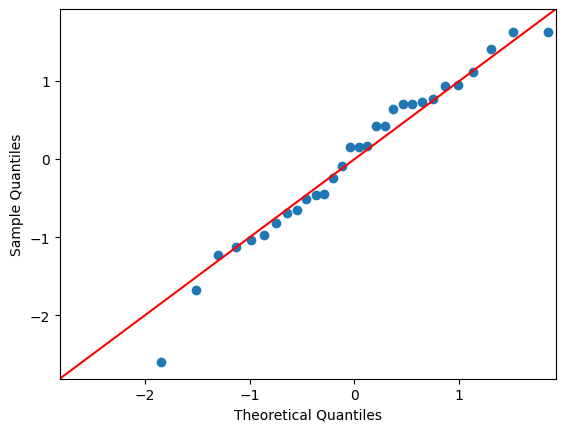

In [44]:
# pomocí QQ grafu
sm.qqplot(aku['kapacita_5'][aku['vyrobce']=='A'], line='45', fit=True)
plt.show()
# rozložení bodů podél přímky ukazuje na normální rozdělení dat

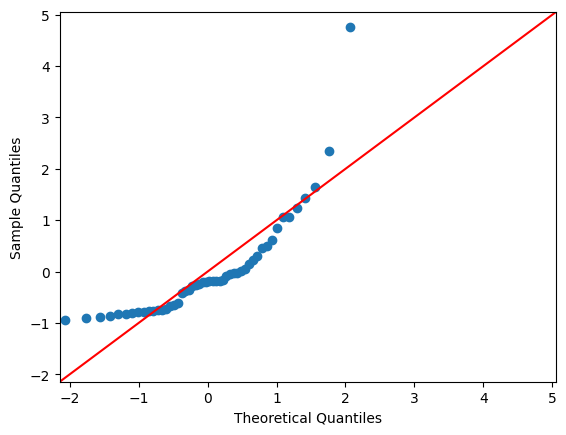

In [35]:
# Obdobný graf pro data z exponenciálního rozdělení ukazuje výrazný odklad od přímky. Z toho lze usuzovat, že data nemají normální rozdělení.
x = np.random.exponential(5, size=50)
sm.qqplot(x, line='45', fit=True)
plt.show()

In [36]:
# normalitu lze testovat např. Shapirovým-Wilkovým testem (H0: data mají normální rozdělení, H1: data nemají normální rozdělení)
stats.shapiro(aku['kapacita_5'][aku['vyrobce']=='A'])
# vyspoká p-hodnota ukazuje, že data nevykazují významnou odchylku od normality 

ShapiroResult(statistic=0.9714747667312622, pvalue=0.5802702307701111)

---

# Testy hypotéz, intervalové odhady

## Ověření normality pro jednotlivé kapacity a výrobce

In [37]:
aku[['kapacita_5', 'vyrobce']].groupby('vyrobce').apply(stats.shapiro)

vyrobce
C     (0.9658654928207397, 0.4130541682243347)
B    (0.9383649826049805, 0.06728947162628174)
A     (0.9714747667312622, 0.5802702307701111)
D     (0.9861743450164795, 0.9459394216537476)
dtype: object

In [38]:
aku[['kapacita_100', 'vyrobce']].groupby('vyrobce').apply(stats.shapiro)

vyrobce
C    (0.9675894975662231, 0.45528578758239746)
B     (0.9734573364257812, 0.5997429490089417)
A     (0.9716190695762634, 0.5843653678894043)
D     (0.9814876317977905, 0.8415120244026184)
dtype: object

Všechny p-hodnoty (ve 2. sloupci) jsou vyšší než 0.05. Jednotlivé výběry můžeme považovat za výbery z normálního rozdělení.

## Jednovýběrový t-test (test střední hodnoty v normálním rozdělení)

Dosahují akumulátory výrobce A po 5 cyklech deklarované kapacity?

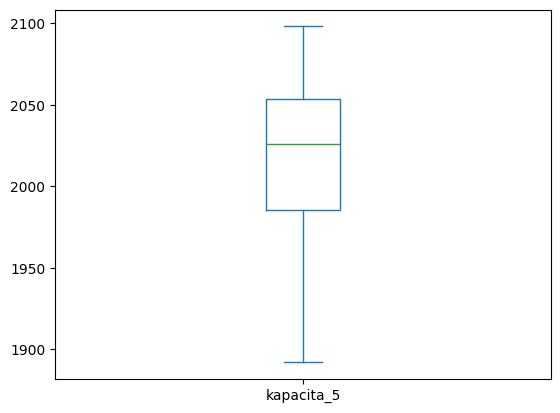

In [41]:
kap5A = aku['kapacita_5'][aku['vyrobce']=='A']
kap5A.plot.box();
# krabicový graf nenaznačuje výraznou odchylku od deklarované hodnoty


Testujeme $H_0$: $\mu_A=2000$ proti $H_1$: $\mu_A\neq 2000$

In [42]:
# oboustranný jednovýběrový t-test
result = stats.ttest_1samp(kap5A, popmean=2000)
print("Jednovýběrový t-test: p-hodnota={:f}".format(result.pvalue))

Jednovýběrový t-test: p-hodnota=0.048518


Na hladině významnosti 0.05 zamítáme $H_0$. Střední hodnota kapacit akumumulátorů výrobce A po 5 cyklech vykazuje statisticky význanou odchylku od deklarované kapacity.

In [44]:
# jednostranný jednovýběrový t-test H0: \mu_A=2000, H1: \mu_A>2000
result = stats.ttest_1samp(kap5A, popmean=2000, alternative='greater')
print("Jednovýběrový t-test: p-hodnota={:f}".format(result.pvalue))

# pro H1: \mu_A<2000 ... alternative='less'
# pro H1: \mu_A<>2000 ... alternative='two-sided' (výchozí hodnota parametru)

Jednovýběrový t-test: p-hodnota=0.024259


---

## Dvouvýběrový t-test (test rovnosti středních hodnot vzájemně neávislých výběrů z normálních rozdělení)

Liší se střední hodnoty kapacit akumulátorů výrobců B a D po 100 cyklech?

In [45]:
kapB100 = aku['kapacita_100'][aku['vyrobce']=='B']
kapD100 = aku['kapacita_100'][aku['vyrobce']=='D']

Text(0, 0.5, 'kapacita')

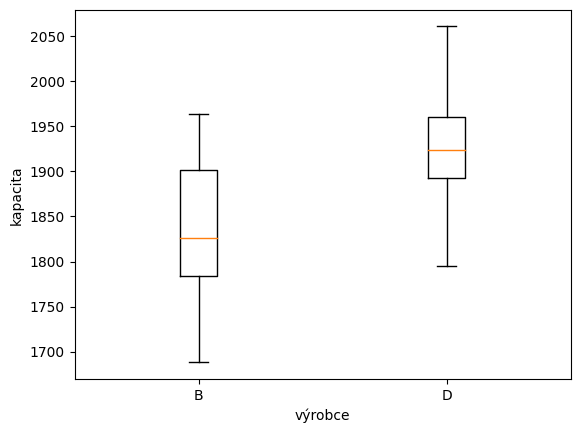

In [46]:
# krabicové grafy pomocí matplotlib
plt.boxplot([kapB100, kapD100])
plt.xticks(ticks=[1, 2], labels=['B', 'D'])
plt.xlabel('výrobce')
plt.ylabel('kapacita')

Krabicové grafy naznačují, že kapacity akamulátorů výrobce D jsou vyšší než výrobce B. Proto volíme jednostrannou alternativní hypotézu.

Krabicové grafy nenaznačjí rozdíl v rozptylech. Použijeme jednostranný t-test pro výběry se shodnými rozptyly.

Test $H_0$: $\mu_B=\mu_D$ proti $H_1$: $\mu_B<\mu_D$

In [47]:
# dvouvýběrový t-test
test = stats.ttest_ind(kapB100, kapD100, equal_var=True)       # pro rozdílné rozptyly: equal_var=False
print("Dvouvýběrový t-test: p-hodnota={:f}".format(test.pvalue))

Dvouvýběrový t-test: p-hodnota=0.000003


Na hladině významnosti 0.05 zamítáme $H_0$. Střední hodnoty kapacit po 100 cyklech akumulátorů výrobce D jsou vyšší než střední hodnoty kapacit akumulátorů výrobce B.

---

## Test shody rozptylů pro dva výběry z normálních rozdělení

Liší se rozptyly hodnoty kapacit akuamulátorů výrobců B a D po 100 cyklech?

$H_0$: $\sigma_B^2=\sigma_D^2$, $H_1$: $\sigma_B^2>\sigma_D^2$

In [48]:
# test rovnosti rozptylů není dostupný v použitých knihovnách, provedeme jej ručně
SB100 = kapB100.var()
SD100 = kapD100.var()
F = SB100/SD100
pval = 1-stats.f.cdf(F, len(kapB100)-1, len(kapD100)-1)
print("F-test: p-hodnota={:f}".format(pval))


F-test: p-hodnota=0.225281


Na hladině významnosti 0.05 nezamítáme $H_0$. U akamulátorů výrobců B a D nebyl po 100 cyklech prokázán rozdíl v rozptylech kapacit.

---

## Párový t-test (test rovnosti středních hodnot pro párová data)

Liší se kapacity akumulátorů výrobce A po 5 a po 100 cyklech?

POZOR: Nejde o nezávislé výběry! Data jsou párová. Měření kapacit po 5 a po 100 cyklech je prováděno se stejnými akumulátory. Posuzujeme stř. hodnotu rozdílů po 5 a po 100 cyklech. 

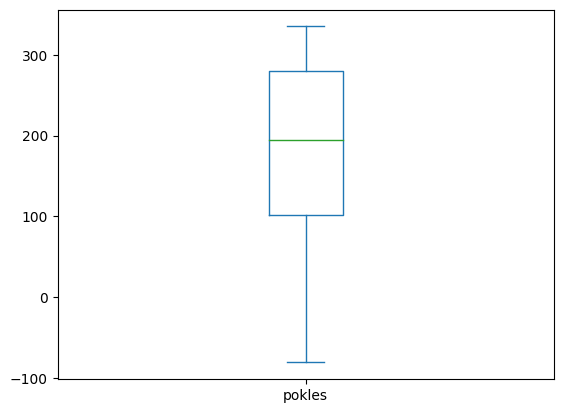

In [49]:
aku['pokles'][aku['vyrobce']=='A'].plot.box();

Krabicový graf ukazuje, že pokles kapacity u výrobce A je výrazně vyšší než 0. 

Ověření normality poklesu kapacit Shapirovým-Wilkovým testem.

In [50]:
stats.shapiro(aku['pokles'])

ShapiroResult(statistic=0.9912384748458862, pvalue=0.6200605630874634)

Hypotézu o normalitě nezamítáme. Poklesy kapacit mají normální rozdělení. Pro test stř. hodnoty poklesu použijeme t-test.

Označme střední hodnotu poklesu kapacity jako $\mu_{pA}$.

Testujeme $H_0$: $\mu_{pA}=0$ proti $H_1$: $\mu_{pA}>0$.

In [51]:
# Chybně (jako nezávislá data):
stats.ttest_ind(aku['kapacita_5'][aku['vyrobce']=='A'], aku['kapacita_100'][aku['vyrobce']=='A'])

Ttest_indResult(statistic=7.402334821424309, pvalue=6.177663764963653e-10)

In [52]:
# Správně pomocí párového t-testu (jako párová data):
stats.ttest_rel(aku['kapacita_5'][aku['vyrobce']=='A'], aku['kapacita_100'][aku['vyrobce']=='A'])

TtestResult(statistic=9.260380518227795, pvalue=3.662123001232633e-10, df=29)

In [53]:
# Správně pomocí jednovýběrového t-testu poklesů:
stats.ttest_1samp(aku['pokles'][aku['vyrobce']=='A'], popmean=0)


TtestResult(statistic=9.260380518227795, pvalue=3.662123001232633e-10, df=29)

In [54]:
result = stats.ttest_rel(aku['kapacita_5'][aku['vyrobce']=='A'], aku['kapacita_100'][aku['vyrobce']=='A'])
print("párový t-test: p-hodnota={:.10f}".format(result.pvalue))


párový t-test: p-hodnota=0.0000000004


Na hladině významnosti 0.05 zamítáme $H_0$. U akamulátorů výrobce A dochází mezi 5 a 100 cyklem k poklesu stř. hodnoty kapacity.

---

## Intervalový odhad střední hodnoty výběru z normálního rozdělení

Intervalové odhady stř. hodot kapacit po 5 cyklech

In [62]:
# ruční výpočet intervalového odhadu  
alfa = 0.05
print('95% intervalové odhady stř. hodnot kapacit po 5 cyklech')
for v in aku['vyrobce'].unique():
    aku_v =  aku['kapacita_5'][aku['vyrobce']==v]  
    m = aku_v.mean() # výběrový průměr
    s = aku_v.std()  # výběrová směrodatná odchylka
    n = len(aku)
    t = stats.t.ppf(1-alfa/2, n-1)  # 1-alfa/2 kvantil studentova rozdělení
    d = t*s/n**0.5 # polovina délky konfidenčního intervalu
    td = m-d # dolní mez
    th = m+d # horn9 mez
    print('výrobce {}: ({:.0f}, {:.0f}) mAh'.format(v, td, th))

95% intervalové odhady stř. hodnot kapacit po 5 cyklech
výrobce A: (2010, 2027) mAh
výrobce B: (1962, 1977) mAh
výrobce C: (1984, 2009) mAh
výrobce D: (2028, 2039) mAh


## ANOVA (test rovnosti stř. hodnot více výběrů z normálních rozdělení)

In [63]:
sloupec = 'pokles' # sloupec s daty pro ANOVu
vyrobci = aku.vyrobce.cat.categories  # hodnoty vysvětlující kategoriální proměnné 
sloupce = [aku[sloupec][aku['vyrobce']==v] for v in vyrobci]  # seznam posloupností s hodnotami v jednotlivych sloupcich

### Explorační analýza

Text(0, 0.5, 'pokles')

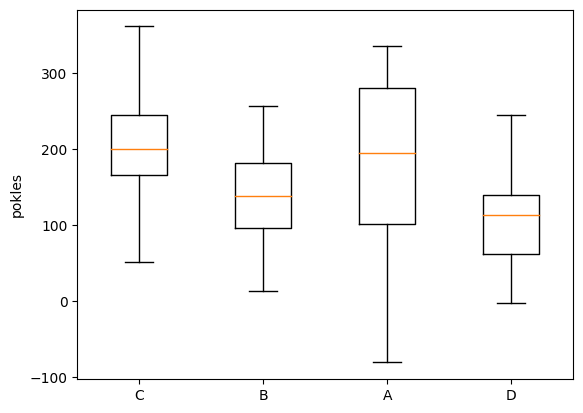

In [64]:
# explorační analýza pomocí krabicových grafů
plt.boxplot(sloupce, labels=vyrobci)
plt.ylabel(sloupec)

Mezi výběry jsou podstatné rozdíly (např. mezi C a D, C a B, A a D). Předběžně lze očekávat, že střední hodnoty nejsou shodné.

### Ověření předpokladů

In [65]:
# oveřní normality jednolivých výberů pomocí Shapirova-Wilkova testu
aku[[sloupec, 'vyrobce']].groupby('vyrobce').apply(stats.shapiro)

vyrobce
C     (0.977180004119873, 0.7305930256843567)
B    (0.9809907078742981, 0.8278498649597168)
A    (0.9489120244979858, 0.1580764502286911)
D     (0.979096531867981, 0.7729222774505615)
dtype: object

P-hodnoty jsou vyšší než 0.05. Hypotézy o normalitě nezamítáme.

In [66]:
# ověření shody rozptylů jednotivych výběrů pomocí Bartlettova testu.
stats.bartlett(*sloupce)

BartlettResult(statistic=13.776323661244252, pvalue=0.0032259783789587654)

P-hodnota 0.003 je nižší než 0.05. Na hladině významnosti 0.05 zamítáme nulovou hypotézu o shodě roztylů. <br>
Pro test rovnosti středních hodnot použijeme Welchovou ANOVu (pro výběry s nestejnými rozptyly).

Testujeme $H_0:\mu_1=\mu_2=\mu_3=\mu_4$ proti $H_1$: neplatí $H_0$.

In [67]:
res_anova = pingouin.welch_anova(aku, dv='pokles', between='vyrobce')
print(res_anova)

    Source  ddof1      ddof2          F     p-unc       np2
0  vyrobce      3  65.573207  10.800051  0.000007  0.184438


In [68]:
print("Welchova ANOVA: p-hodnota={:f}".format(res_anova['p-unc'][0]))

Welchova ANOVA: p-hodnota=0.000007


Na hladině významnosti 0.05 zamítáme $H_0$. Střední hodnoty nejsou shodné.

In [69]:
# post-hoc analýza
pingouin.pairwise_gameshowell(aku, dv='pokles', between='vyrobce')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,C,B,199.129032,134.875000,64.254032,17.371595,3.698799,58.742698,0.002631,0.923062
1,C,A,199.129032,182.933333,16.195699,23.837432,0.679423,51.192166,0.904436,0.172817
2,C,D,199.129032,108.000000,91.129032,17.066894,5.339521,57.716163,0.000010,1.333435
3,B,A,134.875000,182.933333,-48.058333,22.672062,-2.119716,45.987274,0.162115,-0.540625
4,B,D,134.875000,108.000000,26.875000,15.397341,1.745431,61.878774,0.309472,0.431058
5,A,D,182.933333,108.000000,74.933333,22.439451,3.339357,44.753940,0.008900,0.852604


Statisticky významný rozdíl v poklesu kapacity je mezi dvojicemi výrobců (C, B), (C, D) a (A, D).

### Další možnosti vícenásobného porovnání stř. hodnot

In [70]:
# ANOVA pro výběry s nestejnými rozptylyWilcoxon signed-rank test
oneway.anova_oneway(aku[sloupec], aku['vyrobce'], use_var='unequal')

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 10.800051345001934
pvalue = 7.413729881250159e-06
df = (3.0, 65.57320655986469)
df_num = 3.0
df_denom = 65.57320655986469
nobs_t = 125.0
n_groups = 4
means = array([182.93333333, 134.875     , 199.12903226, 108.        ])
nobs = array([30., 32., 31., 32.])
vars_ = array([11707.09885057,  3961.14516129,  5517.5827957 ,  3625.35483871])
use_var = 'unequal'
welch_correction = True
tuple = (10.800051345001934, 7.413729881250159e-06)

In [71]:
# ANOVA pro věýběry se stejnými rozptyly (pomocí stats)
stats.f_oneway(*sloupce)

F_onewayResult(statistic=9.121309719844385, pvalue=1.7255975660772097e-05)

In [72]:
# ANOVA pro výběry se stejnými rozptyly  (pomocí pingouin)
pingouin.anova(aku, dv='pokles', between='vyrobce')

,Source,ddof1,ddof2,F,p-unc,np2
0,vyrobce,3,121,9.12131,0.000017,0.184438


In [73]:
# post-hoc analyza - porovnani str. hodnot jednotlivych dvojic pro stejné rozptyly
tukey_res = pairwise_tukeyhsd(aku[sloupec], aku['vyrobce'])
print(tukey_res)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     A      B -48.0583 0.0791  -99.8393   3.7226  False
     A      C  16.1957 0.8503  -35.9878  68.3792  False
     A      D -74.9333 0.0014 -126.7143 -23.1524   True
     B      C   64.254 0.0078    12.906 115.6021   True
     B      D  -26.875 0.5178  -77.8139  24.0639  False
     C      D  -91.129 0.0001 -142.4771  -39.781   True
-------------------------------------------------------


In [74]:
# Kruskalův-Wallisův test (alternatitva ANOVy pro případ, že výběry nepochází z normalního rozdělení)
#
# Kruskalův-Wallisův test ověřuje shodu rozdělení jednotlivých výběrů. 
# Jestliže rozdělení jednotlivých výběrů mají stejný "tvar" a mohou se lišit jen středními hodnotami (tj. jsou vzájemně posunuta o konstanty),
#    je nulová hypotéza o shodě rozdělení ekvivalentní hypotéze o rovnosti středních hodnot. 
# 
stats.kruskal(*sloupce)

KruskalResult(statistic=24.17659825576398, pvalue=2.2946586382520245e-05)

In [75]:
# post-hoc analyza pro Kruskaluv-Wallisuv test
sp.posthoc_dunn(sloupce)

,1,2,3,4
1,1.000000,0.002278,0.374737,0.000010
2,0.002278,1.000000,0.033063,0.168060
3,0.374737,0.033063,1.000000,0.000488
4,0.000010,0.168060,0.000488,1.000000


In [78]:
%load_ext watermark
%watermark --iversions

pandas         : 1.5.3
numpy          : 1.24.2
scikit_posthocs: 0.8.1
statsmodels    : 0.14.1
matplotlib     : 3.7.5
scipy          : 1.10.1
pingouin       : 0.5.5



In [80]:
from scipy.stats import wilcoxon, mannwhitneyu